In [4]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [5]:
import string
import re
import nltk
stopword=nltk.corpus.stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [7]:
print(df_train.head())

                 id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          0                 0     0       0      0       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0  


In [8]:
print(df_test.head())

                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.


In [9]:
df_train.shape

(159571, 8)

In [10]:
df_train.nunique()

id                  159571
comment_text        159571
malignant                2
highly_malignant         2
rude                     2
threat                   2
abuse                    2
loathe                   2
dtype: int64

In [11]:
df_train.columns.values

array(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude',
       'threat', 'abuse', 'loathe'], dtype=object)

In [12]:
df_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_test.shape

(153164, 2)

<AxesSubplot:xlabel='comment_text'>

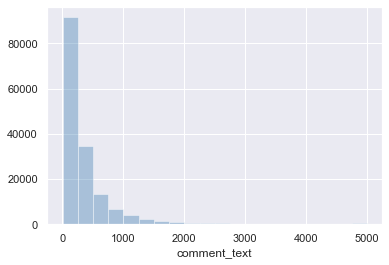

In [14]:
sb.set(color_codes=True)
comment_len = df_train.comment_text.str.len()
sb.distplot(comment_len, kde=False, bins=20, color="steelblue")

In [15]:
# Subsetting labels from the training data
train_labels = df_train[['malignant', 'highly_malignant', 'rude',
                        'threat', 'abuse', 'loathe']]
label_count = train_labels.sum()

<AxesSubplot:title={'center':'Labels Frequency'}>

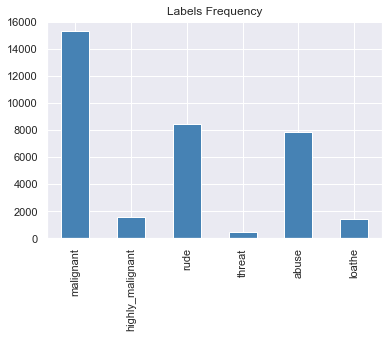

In [16]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [17]:
# example of clean comment
df_train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [18]:
# example of toxic comment
df_train[df_train.malignant == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

<AxesSubplot:>

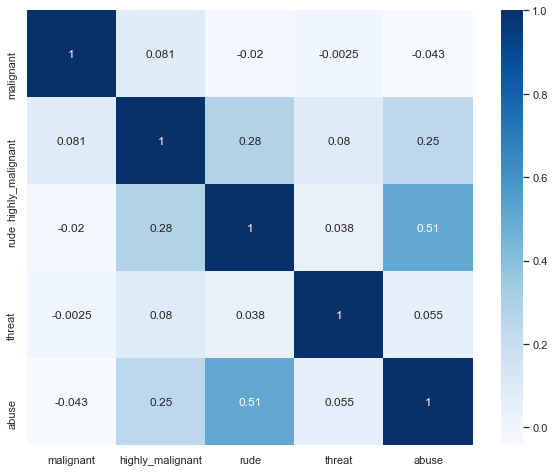

In [19]:
# Cross correlation matrix across labels
rowsums = df_train.iloc[:, 2:].sum(axis=1)
temp = df_train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sb.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

In [20]:
!pip install wordcloud
from wordcloud import WordCloud

In [21]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = df_train[df_train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class to visualize the most common words contributing to the class:malignant


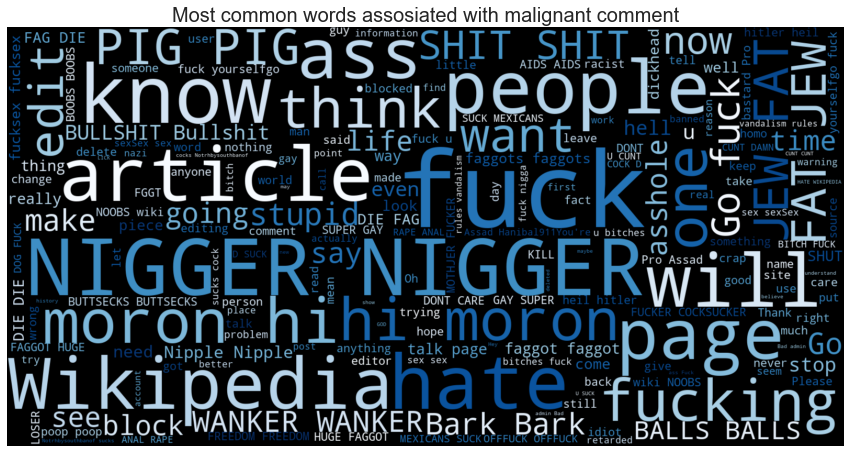

In [22]:
# interactive visual : enter the label name.
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

In [23]:
test_labels = ['malignant', 'highly_malignant', 'rude',
                        'threat', 'abuse', 'loathe']

In [24]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(df_train['comment_text'])
X_test = vector.transform(df_test['comment_text'])

In [27]:
vector.get_feature_names()[0:20]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul']

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [29]:
# Creating classifiers with default parameters initially.
MNB = MultinomialNB()
LR = LogisticRegression()
SV = LinearSVC()

In [30]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [31]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
method1_cv = pd.DataFrame(cross_validation_score(MNB, X_train, df_train))
method2_cv = pd.DataFrame(cross_validation_score(LR, X_train, df_train))
method3_cv = pd.DataFrame(cross_validation_score(SV, X_train, df_train))

In [32]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([method1_cv, method2_cv, method3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,malignant,0.482802,0.636413
1,MultinomialNB,highly_malignant,0.021938,0.042244
2,MultinomialNB,rude,0.469167,0.622148
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,abuse,0.367020,0.511394
5,MultinomialNB,loathe,0.007832,0.015346
6,LogisticRegression,malignant,0.610435,0.731289
7,LogisticRegression,highly_malignant,0.256431,0.351530
8,LogisticRegression,rude,0.636884,0.747280
9,LogisticRegression,threat,0.123316,0.206632


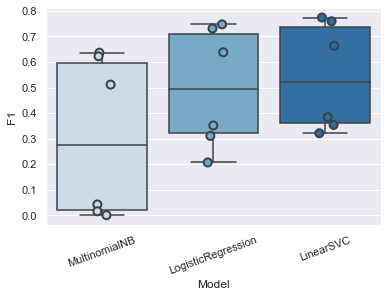

In [33]:
# Visualizing F1 score results through box-plot.
ax = sb.boxplot(x='Model', y='F1', data=methods_cv, palette="Blues")
sb.stripplot(x='Model', y='F1', data=methods_cv,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

Plot for Multinomial Naive Bayes regression


<AxesSubplot:title={'center':'Metrics'}, xlabel='Label'>

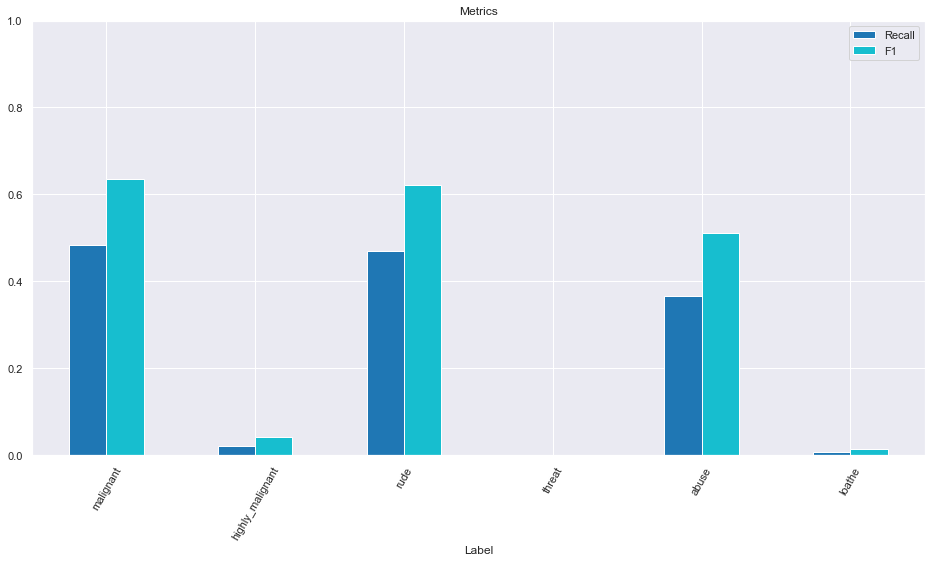

In [34]:
# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods_cv[methods_cv.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


<AxesSubplot:title={'center':'Metrics'}, xlabel='Label'>

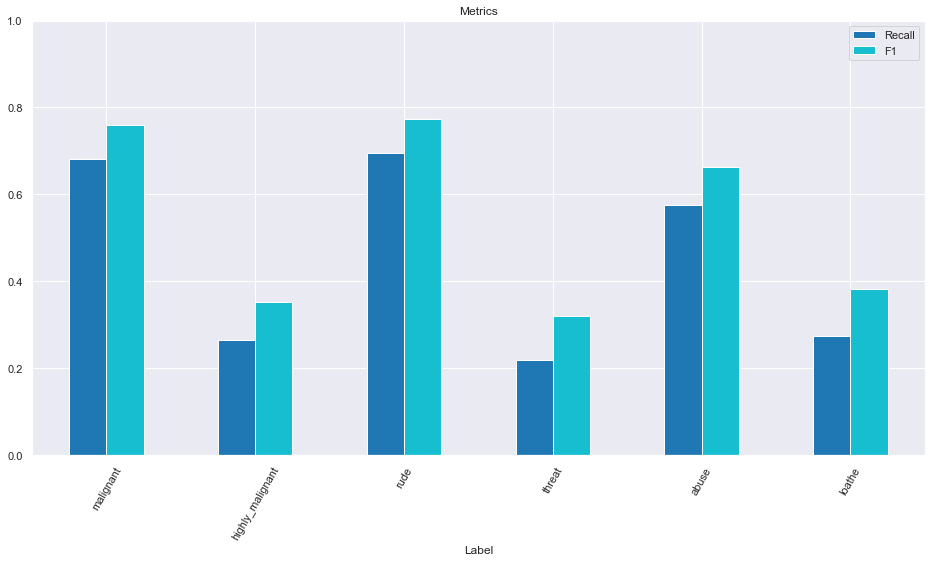

In [35]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods_cv[methods_cv.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


<AxesSubplot:title={'center':'Metrics'}, xlabel='Label'>

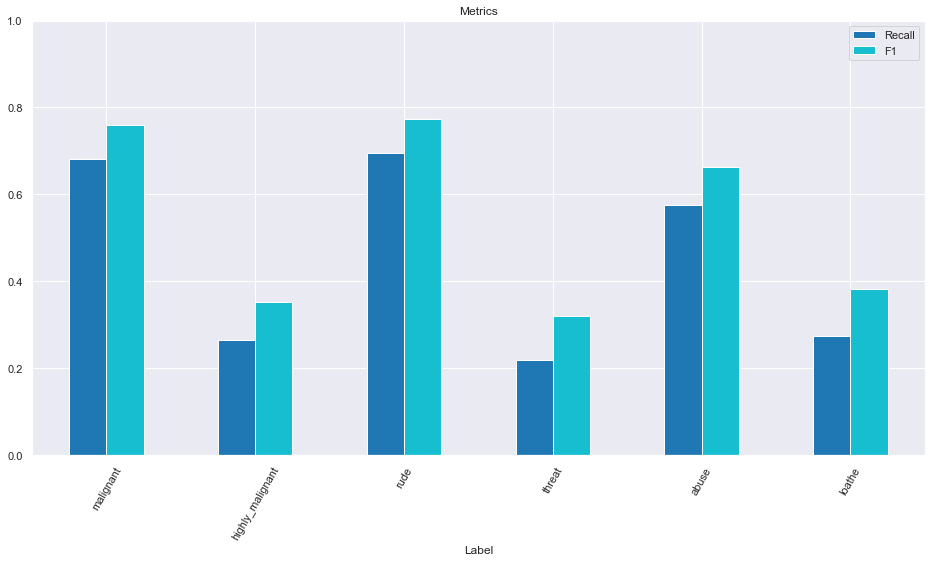

In [36]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods_cv[methods_cv.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

In [37]:
!pip install xgboost
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [38]:
import pickle
filename = 'malignant_result.pkl'
pickle.dump(SV,open(filename,'wb'))

In [51]:
method3_cv.to_csv('malignant_pred.csv')